### The CIFAR-10 Dataset
* Contains 10 categories of images
 * 0 => airplane
 * 1 => automobile
 * 2 => bird
 * 3 => cat
 * 4 => deer
 * 5 => dog
 * 6 => frog
 * 7 => horse
 * 8 => ship
 * 9 => truck

# Loading and preprocessing our dataset

In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical

# Loads the CIFAR dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Display our data shape
num_classes = 10
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Normalizing our data
#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

# Use one hot encoder for our outputs
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)
#print('Example of oneHotEncode: ',y_train[1223],'=> (category 10 )')

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [77]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])
print(x_train.shape)
print(x_train.dtype)

print(y_train.shape)
print(y_train.dtype)

(50000, 3072)
float32
(50000, 1)
float32


In [82]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')


knn = cv2.ml.KNearest_create()
knn.train(x_train, cv2.ml.ROW_SAMPLE, y_train)


True

In [ ]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3])
print(x_test.shape)
ret, results, neighbours ,dist = knn.findNearest(x_test, 3)

(10000, 3072)


# Linear model
* If you can extract SIFTs, the Bag Of Words can be summarized as follows:
 * 1) given a training set of images, extract SIFT from them
 * 2) compute K-Means over the entire set of SIFTs extracted form the training set.
the "K" parameter (the number of clusters) depends on the number of SIFTs that you have for training, but usually is around 500->8000 (the higher, the better).
Now you have obtained K cluster centers.
 * 3) You can compute the descriptor of an image by assigning each SIFT of the image to one of the K clusters. In this way you obtain a histogram of length K.
The histogram must be normalized, for example with L1 norm.
 * 4) Given the descriptors (K-dimensional) you can use SVMs to learn a classifier.

## Extract features from our images with SIFT

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

x_train_gray = np.zeros((x_train.shape[0],x_train.shape[1],x_train.shape[2]))
x_test_gray = np.zeros((x_test.shape[0],x_test.shape[1],x_test.shape[2]))

for i in range(x_train.shape[0]):
    x_train_gray[i] = cv.cvtColor(x_train[i], cv.COLOR_BGR2GRAY)

for i in range(x_test.shape[0]):
    x_test_gray[i] = cv.cvtColor(x_test[i], cv.COLOR_BGR2GRAY)

In [70]:
# Applying our SIFT algorithm
# requierements: pip install opencv-python==3.4.2.16   pip install opencv-contrib-python==3.4.2.16


descriptions = []

x_train_gray = cv.normalize(x_train_gray, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
x_test_gray = cv.normalize(x_test_gray, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

sift = cv.xfeatures2d.SIFT_create()
for i in range(x_train_gray.shape[0]):
    #image8bit = cv2.normalize(x_train_gray[1], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    keypoint, desc = sift.detectAndCompute(x_train_gray[i], None)
    if desc is not None:
        for j in range(len(desc)):
            descriptions.append(desc[j])
#plt.imshow(cv2.drawKeypoints(image8bit, keypoint, x_train[1].copy()))
print("number of features :",len(descriptions))

## Clustering with KMeans

In [73]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

k = num_classes * 10
batch_size = 128 * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=0)
kmeans.fit(descriptions)

MiniBatchKMeans(batch_size=384, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

## Creation of the histograms

In [75]:
kmeans.verbose = False

histo_list = []

for i in range(x_train.shape[0]):
    kp, desc = sift.detectAndCompute(x_train_gray[i], None)

    histo = np.zeros(k)
    nkp = np.size(kp)

    if desc is not None:
        for d in desc:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

## Training our SVM model

In [79]:
from sklearn.svm import SVC

X = np.array(histo_list)

#classifier = SVC(gamma=0.001,max_iter=)
classifier = SVC(kernel='linear', gamma='auto')

classifier.fit(X, y_train)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[0.05555556 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05555556 0.         ... 0.         0.         0.        ]
 [0.07692308 0.         0.         ... 0.         0.15384615 0.        ]
 ...
 [0.05263158 0.         0.         ... 0.         0.         0.        ]
 [0.         0.08333333 0.         ... 0.         0.         0.08333333]
 [0.         0.11111111 0.         ... 0.         0.         0.        ]]


ValueError: x and y must be the same size

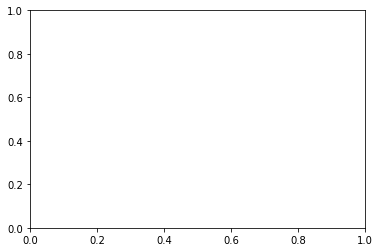

In [153]:
print(X)

plt.scatter(X[0], y_train[0],  cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')


plt.show()

## Prediction

In [141]:
y_pred = []

train_samples = y_train.shape[0]
test_samples = y_test.shape[0]


for i in range(test_samples):
    keypoint, desc = sift.detectAndCompute(x_test_gray[i], None)

    x = np.zeros(k)
    nkp = np.size(kp)

    if desc is not None:
        for d in desc:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp

    result = classifier.predict([x])
    y_pred.append(result[0])

accuracy : 0.1998 %


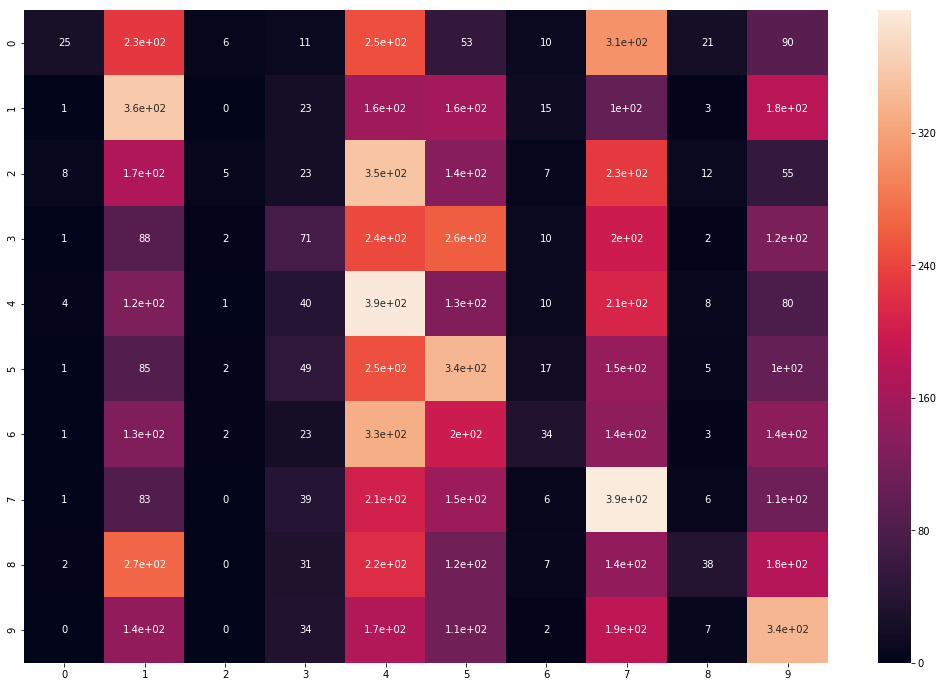

In [142]:
from sklearn.metrics import confusion_matrix

true = 0

for i in range(test_samples):
    if y_test[i] == y_pred[i]:
        true += 1
print("accuracy :", true/test_samples,"%")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(18,12))
sns.heatmap(cm, annot = True)

(array([  44., 1681.,   18.,  344., 2571., 1657.,  118., 2062.,  105.,
        1400.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

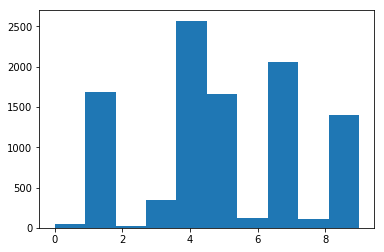

In [143]:
plt.hist(y_pred)

In [ ]:
plt.plot(x_test)

In [120]:
# https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
# https://www.kaggle.com/carloskl12/model-with-sift-descriptors